In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import time

Алгорит Харриса для CPU

Результат алгоритма:


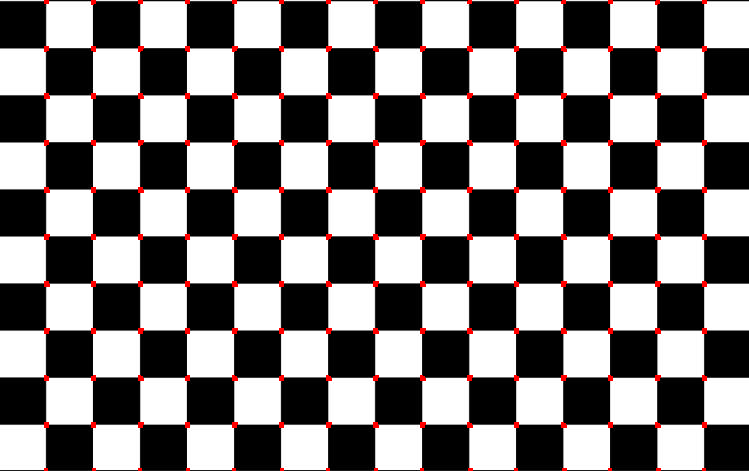

Время вычисления на CPU: 0.8245


In [3]:
start = time.time()

filename = '/content/drive/MyDrive/image/chess.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

print('Результат алгоритма:')
cv2_imshow(img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

end  = time.time() - start
print('Время вычисления на CPU: {:2.4f}'.format(end))

Алгоритм Харриса для GPU

In [4]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 1.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.6 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=3efb6bdc40c1326f76daf7e4077a6d25ad452d0b6ab3d98770c468eb76286385
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=61b4a1810aed6697691f41f552ebdd6f3617a660d33f624cedfda52d09e808ff
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [5]:
from string import Template
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

def Harris_GPU(img, k, thresh):

    height = img.shape[0]
    width = img.shape[1]

    vector_size = img.shape[0] * img.shape[1]
    corner_list = []
    offset = 2
    # to fit still in a 32-bit integer
    thresh = int(thresh/10)

    # function template
    func_mod_template = Template("""
    #include<stdio.h>
    #define INDEX(a, b) a*${HEIGHT}+b

    __global__ void corners(
        float *dest,
        float *ixx,
        float *ixy,
        float *iyy,
        int offset,
        float k,
        int threshold) {

        unsigned int idx = threadIdx.x + threadIdx.y*blockDim.y +
                            (blockIdx.x*(blockDim.x*blockDim.y));

        unsigned int a = idx/${HEIGHT};
        unsigned int b = idx%${HEIGHT};

        float sxx = 0;
        float sxy = 0;
        float syy = 0;
        float det = 0;
        float trace = 0;
        float r = 0;

        if ((a >= offset) & (a <= (${WIDTH}-offset - 1)) &
            (b >= offset) & (b <= (${HEIGHT}-offset - 1))) {
            for (int bi = b - offset; bi < b + offset + 1; ++bi) {
                for (int ai = a - offset; ai < a + offset + 1; ++ai) {
                    sxx = sxx + ixx[INDEX(ai, bi)];
                    sxy = sxy + ixy[INDEX(ai, bi)];
                    syy = syy + iyy[INDEX(ai, bi)];
                }
            }
            det = sxx*syy - sxy*sxy;
            trace = sxx + syy;
            r = det - k*(trace*trace);
            if ((r/10) > threshold)
                dest[INDEX(a, b)] = r;
        }
    }
    """)

    func_mod = SourceModule(func_mod_template.substitute(HEIGHT=height,
                                                         WIDTH=width))
    pycuda_corners = func_mod.get_function("corners")

    # Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    ixx = Ixx.reshape(vector_size, order='F')
    ixy = Ixy.reshape(vector_size, order='F')
    iyy = Iyy.reshape(vector_size, order='F')
    dest_r = np.zeros_like(ixx)

    # start timer
    start = timeit.default_timer()

    pycuda_corners(drv.Out(dest_r),
                drv.In(ixx),
                drv.In(ixy),
                drv.In(iyy),
                np.uint32(offset),
                np.float32(k),
                np.uint32(thresh),
                block=(32, 32, 1),  
                grid=(height*width//1024, 1, 1))  

    # calculate used time
    execution_time = timeit.default_timer() - start

    # extract the corners
    r = np.reshape(dest_r, (height, width), order='F')
    corners = np.where(r > 0)
    for i, j in zip(corners[0], corners[1]):
        corner_list.append([j, i, r[i, j]])

    return corner_list, execution_time

Исходное изображение:


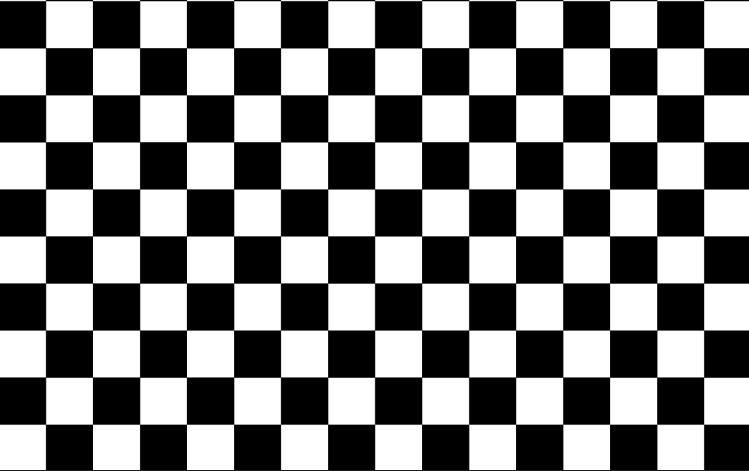

In [12]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/drive/MyDrive/image/chess.png', 0).astype(np.float32)
print('Исходное изображение:')
cv2_imshow(image)

Время вычисления на GPU: 0.1142
Результат выполнения алгоритма на GPU:


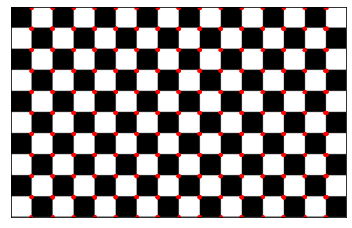

In [11]:
import matplotlib.pyplot as plt
import timeit

k = 0.05
thresh = 3000000000
# run the algorithm
start = time.time()
corners, timed = Harris_GPU(image, k, thresh)
end = time.time() - start
print('Время вычисления на GPU: {:2.4f}'.format(end))

# plot the image and a red dot at the corners
print('Результат выполнения алгоритма на GPU:')
n_image = np.zeros(image.shape) 
fig = plt.imshow(image, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.scatter([x[0] for x in corners], [x[1] for x in corners], s=1, c = 'red')
plt.savefig('/content/drive/MyDrive/image/GPU_chess.png')
plt.show()